In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import KFold

In [61]:
arr = np.genfromtxt('data/chips.csv', delimiter=',')
xs, ys = arr[:,:2].copy(), np.int32(arr[:, 2:].ravel())

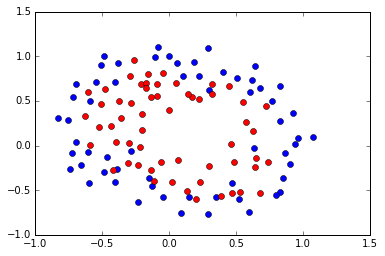

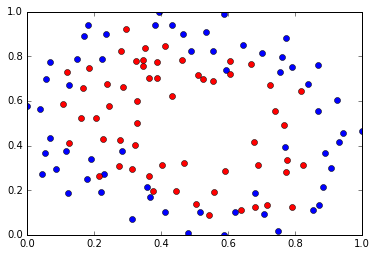

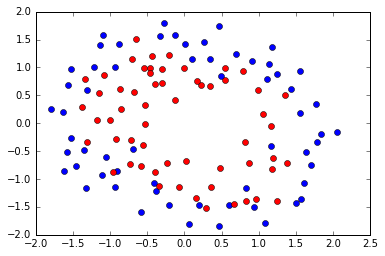

In [62]:
def show(xs, ys):
    plt.plot(xs[ys==0][:, 0], xs[ys==0][:, 1], 'bo')
    plt.plot(xs[ys==1][:, 0], xs[ys==1][:, 1], 'ro')
    plt.show()
show(xs, ys)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(xs)
show(x_scaled, ys)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(xs)
show(x_scaled, ys)

In [97]:
# http://stats.stackexchange.com/questions/44166/kernelised-k-nearest-neighbour
def knn(x, data, labels, k, weight_f='uniform', metric_f='L2', kernel_f='id', scaler=None):
    if kernel_f == 'id':
        kernel_f = lambda x: x
    if weight_f == 'uniform':
        weight_f = lambda x: x
    if metric_f == 'L2':
        metric_f = lambda x, y: ((x-y)**2).sum()**0.5
    if scaler is not None:
        data = scaler.transform(data)
    f = lambda t: weight_f(metric_f(kernel_f(x), kernel_f(t)))
    arr = np.apply_along_axis(f, 1, data)
    neighbors = np.argsort(arr)[:k]
    neighbors_labels = labels[neighbors]
    x_label = np.bincount(neighbors_labels).argmax()
    return x_label


In [142]:
def f1_score(predicted, true):
    tp = ((predicted == true) * (predicted == 1)).sum()
    fp = ((predicted != true) * (predicted == 1)).sum()
    fn = ((predicted != true) * (predicted == 0)).sum()
    p = tp*1.0/(tp+fp)
    r = tp*1.0/(tp+fn)
    return 2*p*r/(p+r)
    
def kf_cross_validation(xs, ys, n_fold=10, measure='accuracy', **params):
    if measure == 'accuracy':
        measure = lambda x, y: (x==y).sum() * 1.0/len(x)
    kf = KFold(len(xs), n_fold, True)
    kf_sum = 0
    for train_i, test_i in kf:
        classifier = lambda x: knn(x, xs[train_i], ys[train_i], **params)
        true_labels = ys[test_i]
        predicted_labels = np.apply_along_axis(classifier, 1, xs[test_i])
        kf_sum += measure(predicted_labels, true_labels)
    return kf_sum/n_fold

In [159]:
kf_cross_validation(xs, ys, 10, f1_score, k=5)

0.71049450549450544